# Testing Mango

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('..')+'/classifiers')

In [2]:
from tuner import Tuner

In [3]:
from domain.distribution import loguniform

param_dict = {"changepoint_prior_scale": loguniform(-3, 1),
              'seasonality_prior_scale' : loguniform(-1, 2)
             }

# userObjective on Celery

In [4]:
from CeleryTasks import run_prophet

iteration_count = 1

def objective_Prophet(args_list):
    global iteration_count
    
    print('iteration_count:',iteration_count)
    
    iteration_count = iteration_count+1
    process_queue =[]
    
    for hyper_par in args_list:
        process = run_prophet.delay(hyper_par)
        process_queue.append(process)
    
    results = []
    for process in process_queue:
        result = process.get(timeout=100)
        results.append(result)
           
    return results

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [5]:
conf_Dict = dict()
conf_Dict['batch_size'] = 4
conf_Dict['num_iteration'] = 10

# Defining Tuner

In [6]:
tuner_user = Tuner(param_dict, objective_Prophet,conf_Dict)

In [7]:
tuner_user.getConf()

{'param_dict': {'changepoint_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a178562b0>,
  'seasonality_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a178567f0>},
 'userObjective': <function __main__.objective_Prophet(args_list)>,
 'domain_size': 5000,
 'initial_random': 1,
 'num_iteration': 10,
 'objective': 'maximize',
 'batch_size': 4}

In [8]:
results = tuner_user.run()

iteration_count: 1
iteration_count: 2
iteration_count: 3
iteration_count: 4
iteration_count: 5
iteration_count: 6
iteration_count: 7
iteration_count: 8
iteration_count: 9
iteration_count: 10
iteration_count: 11


# Inspect the results

In [9]:
print('best hyper parameters:',results['best_hyper_parameter'])
print('best objective:',results['best_objective'])

best hyper parameters: {'changepoint_prior_scale': 0.003234105026868094, 'seasonality_prior_scale': 9.993897751797054}
best objective: -9.978044248021373


In [10]:
print('Sample hyper parameters tried:',len(results['hyper_parameters_tried']))
print(results['hyper_parameters_tried'][:2])

Sample hyper parameters tried: 41
[{'changepoint_prior_scale': 0.005854466553912526, 'seasonality_prior_scale': 9.21240946674169}, {'changepoint_prior_scale': 0.003180006494329888, 'seasonality_prior_scale': 0.10101051148217402}]


In [11]:
print('Sample objective values',len(results['objective_values']))
print(results['objective_values'][:5])

Sample objective values 41
[-10.020587529172666, -9.979741420164784, -9.983937497631906, -10.088438766835663, -9.98431418957915]


# Plotting the actual variation in objective values of the tried results

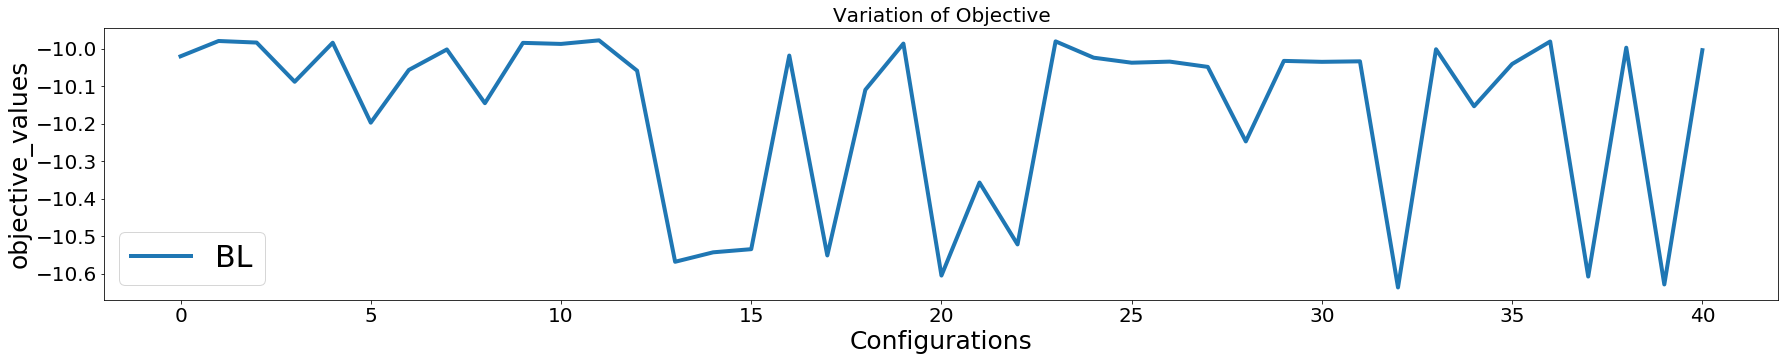

In [12]:
Size = 201 

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Variation of Objective',fontsize=20)
plt.plot(results['objective_values'][:Size],lw=4,label='BL')
plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# Plotting the variation of Max objective values of the tried results

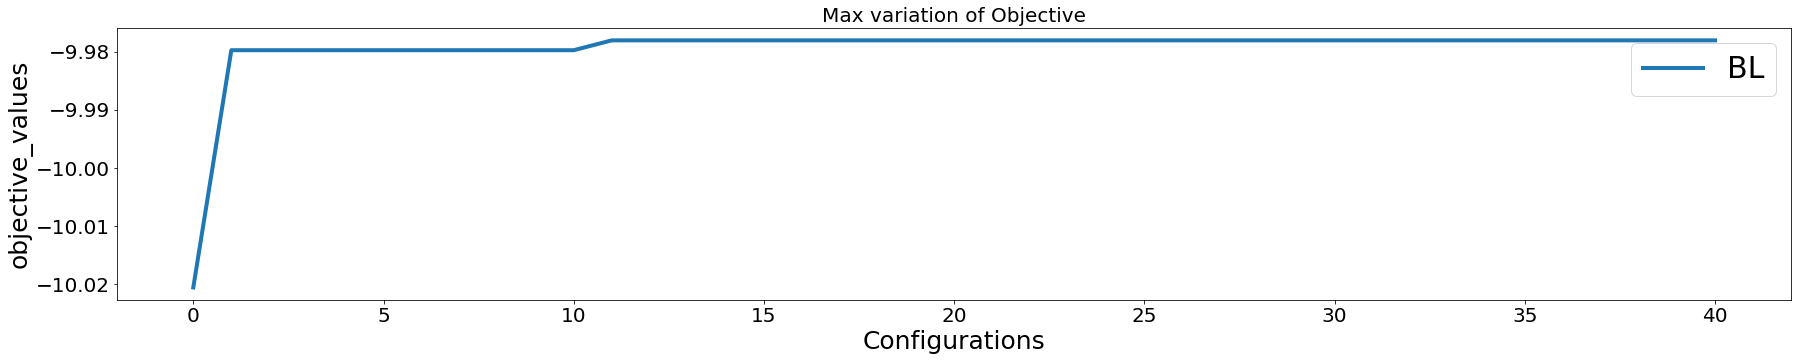

In [13]:
Size = 201 

import numpy as np

results_obj = np.array(results['objective_values'])

y_max=[]
for i in range(results_obj.shape[0]):
    y_max.append(np.max(results_obj[:i+1]))

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)
plt.plot(y_max[:Size],lw=4,label='BL')
plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# See the Result

In [14]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

{   'best_hyper_parameter': {   'changepoint_prior_scale': 0.003234105026868094,
                                'seasonality_prior_scale': 9.993897751797054},
    'best_objective': -9.978044248021373,
    'hyper_parameters_tried': [   {   'changepoint_prior_scale': 0.005854466553912526,
                                      'seasonality_prior_scale': 9.21240946674169},
                                  {   'changepoint_prior_scale': 0.003180006494329888,
                                      'seasonality_prior_scale': 0.10101051148217402},
                                  {   'changepoint_prior_scale': 0.00367181513004619,
                                      'seasonality_prior_scale': 3.4817970877013904},
                                  {   'changepoint_prior_scale': 0.0019222321478342822,
                                      'seasonality_prior_scale': 3.4886682671992575},
                                  {   'changepoint_prior_scale': 0.003421198537848636,
                    

#  See the learned classifier result on the test data

In [17]:
from classifiers.prophet import Prophet
from classifiers.xgboosttree import Xgboosttree
model = Xgboosttree()

X_train, y_train = model.load_train_dataset("../classifiers/data/PJME/train_data")
X_test, y_test = model.load_train_dataset("../classifiers/data/PJME/test_data")
X_validate, y_validate = model.load_train_dataset("../classifiers/data/PJME/validate_data")


model = Prophet(**results['best_hyper_parameter'])
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test) 

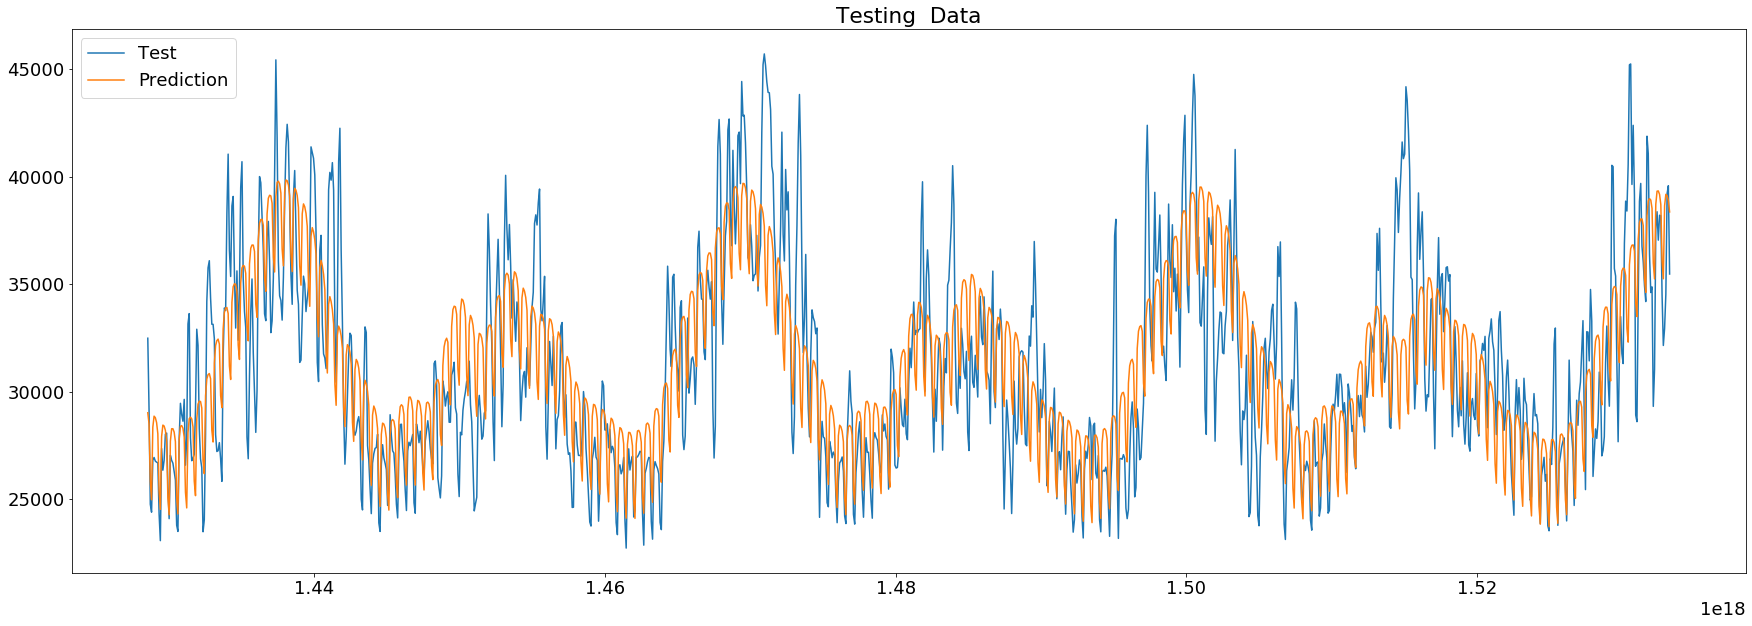

In [18]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_test,y_test,label='Test')
plt.plot(X_test,y_pred,label='Prediction')
plt.title('Testing  Data')
plt.legend()
plt.show()

# All the Data

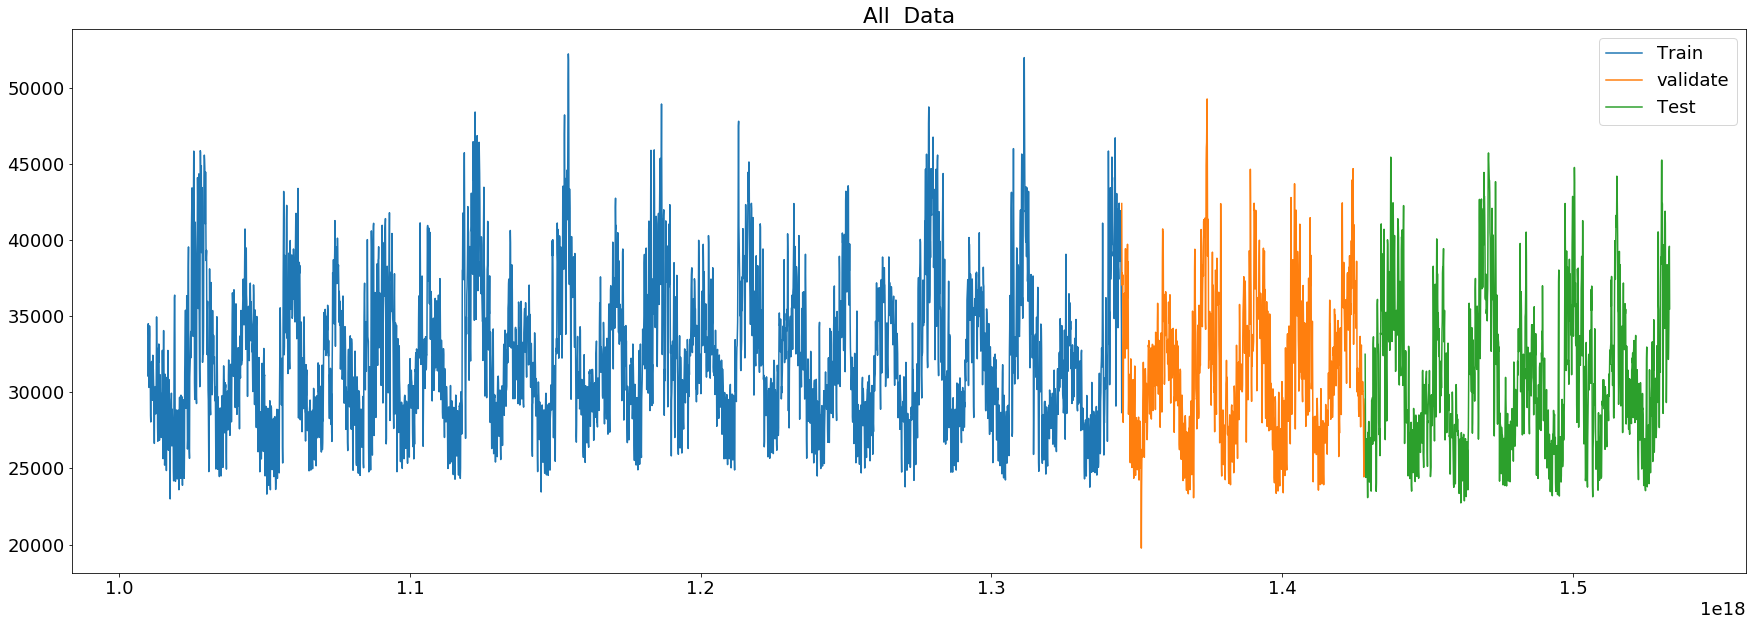

In [19]:
from classifiers.xgboosttree import Xgboosttree

model = Xgboosttree()

X_train, y_train = model.load_train_dataset("../classifiers/data/PJME/train_data")
X_test, y_test = model.load_train_dataset("../classifiers/data/PJME/test_data")
X_validate, y_validate = model.load_train_dataset("../classifiers/data/PJME/validate_data")

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_train,y_train,label='Train')
plt.plot(X_validate,y_validate,label='validate')
plt.plot(X_test,y_test,label='Test')
plt.title('All  Data')
plt.legend()
plt.show()

